# Logits to Normal Distribution

In [1]:
import os
import sys
import math
import time
import random
import tempfile
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from IPython.display import HTML
from scipy.special import softmax

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.distributions import MultivariateNormal

from utils.visualization import plot_prob_simplex, plot_cal_regions_ternary

In [2]:
%matplotlib inline
plt.ioff()

In [3]:
n_samples = 1500
dim = 3

PI = torch.Tensor([math.pi])

In [4]:
def create_animation_logits(intermediate_results):
    
    preds = intermediate_results[0]
    
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(20, 45)

    sc = ax.scatter(preds[:, 0], preds[:, 1], preds[:, 2], c=target)

    # manually relim:
    xmin = 1e7; xmax = 1e-7;
    ymin = 1e7; ymax = 1e-7;
    zmin = 1e7; zmax = 1e-7;
    for preds in intermediate_results:
        xmin=min(preds[:,0].min(), xmin); xmax=max(preds[:,0].max(), xmax)
        ymin=min(preds[:,1].min(), ymin); ymax=max(preds[:,1].max(), ymax)
        zmin=min(preds[:,2].min(), zmin); zmax=max(preds[:,2].max(), zmax)

    xmin = max(xmin, -10.); xmax = min(xmax, 10.)
    ymin = max(xmin, -10.); ymax = min(ymax, 10.)
    zmin = max(xmin, -10.); zmax = min(zmax, 10.)

    ax.set_xlim(xmin-0.1*(xmax-xmin),xmax+0.1*(xmax-xmin))
    ax.set_ylim(ymin-0.1*(ymax-ymin),ymax+0.1*(ymax-ymin))
    ax.set_zlim(zmin-0.1*(zmax-zmin),zmax+0.1*(zmax-zmin))

    def update_scat(i):
        preds = intermediate_results[i]
        sc._offsets3d = (preds[:, 0], preds[:, 1], preds[:, 2])

    ani = animation.FuncAnimation(fig, update_scat, frames=len(intermediate_results), interval=30)
    
    return ani

In [ ]:
def create_animation_simplex(intermediate_results):
    
    fig, ax = plt.subplots()
    
    probs = softmax(intermediate_results[0], 1)
    
    ax = plot_prob_simplex(probs, target, ax=ax, title='Output probabilities')
    
    def update_scat(i):
        preds = intermediate_results[i]
        probs = softmax(preds, 1)
        ax = plot_prob_simplex(probs, target, ax=ax, title='Output probabilities')

    ani = animation.FuncAnimation(fig, update_scat, frames=len(intermediate_results), interval=30)
    
    return ani

## Base distribution, Uncalibrated Logits

In [5]:
target = np.array(random.choices(range(3), k=n_samples))
one_hot = np.zeros((n_samples, 3))
one_hot[np.arange(n_samples), target] = 1.

# Shift
offset = np.zeros((n_samples, 3))
offset[:, 1:] = 0.05

# Twist
twisting = np.zeros((n_samples, 3))
twisting[np.arange(n_samples), target-1] = 0.7 + np.random.randn(n_samples)*0.1

logits = np.float32(0.8 * (one_hot + twisting + np.random.randn(n_samples, 3)*0.3) + offset)

# Equivalent to log(softmax())
logits -= np.log(np.sum(np.exp(logits), axis=1, keepdims=True))

probs = softmax(logits, axis=1)

# Convert data to torch tensors.
torch_logits = torch.as_tensor(logits, dtype=torch.float)
torch_target = torch.as_tensor(target, dtype=torch.long)


In [6]:
def nll(probs):
    return np.mean(-np.log(probs[np.arange(probs.shape[0]), target]))

In [7]:
# Uncalibrated NLL
print(nll(probs))

0.8271444


## Define Flows

In [8]:
class MLP(nn.Module):
    def __init__(self, dim, hidden_size=[], activation=F.relu):
        super(MLP, self).__init__()
        self.activation = activation
        units = [dim] + hidden_size + [dim]
        self.layers = nn.ModuleList([nn.Linear(units[i], units[i+1])
                                     for i in range(len(units)-1)])

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        y = self.layers[-1](x)

        return y

In [9]:
class AffineConstantLayer(nn.Module):

    def __init__(self, dim, scale=True, shift=True):
        super(AffineConstantLayer, self).__init__()

        self.s = nn.Parameter(torch.randn(1, dim, requires_grad=True)) \
            if scale else None
        self.t = nn.Parameter(torch.randn(1, dim, requires_grad=True)) \
            if shift else None

    def forward(self, x):
        s = self.s if self.s is not None else x.new_zeros(x.size())
        t = self.t if self.t is not None else x.new_zeros(x.size())
        z = x * torch.exp(s) + t
        log_det = torch.sum(s, dim=1)
        return z, log_det

    def backward(self, z):
        s = self.s if self.s is not None else z.new_zeros(z.size())
        t = self.t if self.t is not None else z.new_zeros(z.size())
        x = (z - t) * torch.exp(-s)
        log_det = torch.sum(-s, dim=1)
        return x, log_det

In [10]:
class NvpCouplingLayer(nn.Module):
    def __init__(self, dim, hidden_size=[5, 5], random_mask=True, max_abs=None):
        super(NvpCouplingLayer, self).__init__()
        self.s = MLP(dim, hidden_size)
        self.t = MLP(dim, hidden_size)
        
        # Use random partitioning of the data
        mask = np.random.randint(2, size=dim)
        if random_mask:
            while mask.sum() < 1 or mask.sum() == dim:
                mask = np.random.randint(2, size=dim)
        else:
            mask = np.zeros((1, dim))
            mask[:, dim//2:] = 1
            
        self.mask = nn.Parameter(
                torch.as_tensor(mask.copy(), dtype=torch.float),
                requires_grad=False)
        
        self.max_abs = max_abs

    def forward(self, x):
        x_b = self.mask*x
        b_1 = 1 - self.mask

        s, t = self.s(x_b), self.t(x_b)
        y = x_b + b_1 * (x * torch.exp(s) + t)

        log_det = torch.sum(b_1*s, dim=1).squeeze()
        
        if self.max_abs is not None:
            log_det -= torch.clamp(torch.abs(torch.sum(y, dim=1)), min=self.max_abs)

        return y.flip((1,)), log_det

    def backward(self, x):
        x_b = self.mask*x
        b_1 = 1 - self.mask

        s, t = self.s(x_b), self.t(x_b)
        y = x_b + b_1*((x - t) * torch.exp(-s))

        log_det = torch.sum(b_1*(-s), dim=1).squeeze()
        
        if self.max_abs is not None:
            log_det -= torch.clamp(torch.abs(torch.sum(y, dim=1)), min=self.max_abs)

        return y.flip((1,)), log_det

In [11]:
class Flow(nn.Module):
    def __init__(self, layers, **kwargs):
        super(Flow, self).__init__()

        self.layers = nn.ModuleList(layers)
        self.log_det = nn.Parameter(torch.zeros(1), requires_grad=False)

    def forward(self, x):
        cum_log_det = self.log_det.new_full((x.shape[0],), fill_value=0)
        for layer in self.layers:
            x, log_det = layer(x)
            cum_log_det += log_det
            
        return x, cum_log_det
            
    def backward(self, x):
        cum_log_det = self.log_det.new_full((x.shape[0],), fill_value=0)
        for layer in self.layers[::-1]:
            x, log_det = layer.backward(x)
            cum_log_det += log_det

        return x, cum_log_det

## Create flow

In [12]:
model = Flow(layers=[NvpCouplingLayer(dim, [5, 5], random_mask=False) for _ in range(10)])
dev = torch.device('cpu')

## Train flow

In [13]:
epochs = 15000

In [14]:
model = model.to(dev, non_blocking=True)

# Instantiate optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

loss = []
logpz = []
logdet = []

intermediate_results = []

# Train loop
t0 = time.time()
for e in range(epochs):

    cum_loss = torch.zeros(1, device=dev)
    cum_logdet = torch.zeros(1, device=dev)
    cum_logprior = torch.zeros(1, device=dev)

    optimizer.zero_grad()

    preds, _logdet = model(torch_logits)

    _logdet = torch.mean(_logdet)
    _logpz = torch.mean(-0.5 * (3.0 * torch.log(2*PI) + torch.sum(torch.pow(preds, 2), dim=1)))
    _loss = -_logpz - _logdet

    _loss.backward()
    optimizer.step()

    loss.append(_loss.item())
    logpz.append(_logpz.item())
    logdet.append(_logdet.item())

    if e%10 == 9:
        print('epoch: {}, at time: {:.2f}, loss: {:.3f}, log(pz): {:.3f}, log(det): {:.3f}'.format(e, time.time()-t0, loss[-1], logpz[-1], logdet[-1]))
        intermediate_results.append(preds.detach().numpy())

epoch: 9, at time: 1.03, loss: 5.927, log(pz): -4.237, log(det): -1.690
epoch: 19, at time: 1.63, loss: 5.888, log(pz): -4.229, log(det): -1.659
epoch: 29, at time: 2.30, loss: 5.849, log(pz): -4.222, log(det): -1.628
epoch: 39, at time: 2.89, loss: 5.811, log(pz): -4.214, log(det): -1.597
epoch: 49, at time: 3.51, loss: 5.773, log(pz): -4.207, log(det): -1.566
epoch: 59, at time: 4.16, loss: 5.734, log(pz): -4.200, log(det): -1.535
epoch: 69, at time: 4.81, loss: 5.696, log(pz): -4.192, log(det): -1.504
epoch: 79, at time: 5.46, loss: 5.658, log(pz): -4.185, log(det): -1.473
epoch: 89, at time: 6.07, loss: 5.619, log(pz): -4.177, log(det): -1.442
epoch: 99, at time: 6.74, loss: 5.581, log(pz): -4.170, log(det): -1.411
epoch: 109, at time: 7.34, loss: 5.542, log(pz): -4.162, log(det): -1.380
epoch: 119, at time: 8.01, loss: 5.504, log(pz): -4.155, log(det): -1.349
epoch: 129, at time: 8.61, loss: 5.465, log(pz): -4.147, log(det): -1.318
epoch: 139, at time: 9.21, loss: 5.426, log(pz): 

epoch: 1119, at time: 72.51, loss: 1.756, log(pz): -4.230, log(det): 2.474
epoch: 1129, at time: 73.19, loss: 1.719, log(pz): -4.225, log(det): 2.506
epoch: 1139, at time: 73.85, loss: 1.681, log(pz): -4.218, log(det): 2.537
epoch: 1149, at time: 74.52, loss: 1.641, log(pz): -4.212, log(det): 2.571
epoch: 1159, at time: 75.11, loss: 1.599, log(pz): -4.203, log(det): 2.604
epoch: 1169, at time: 75.81, loss: 1.556, log(pz): -4.195, log(det): 2.639
epoch: 1179, at time: 76.43, loss: 1.512, log(pz): -4.185, log(det): 2.673
epoch: 1189, at time: 76.98, loss: 1.468, log(pz): -4.176, log(det): 2.708
epoch: 1199, at time: 77.61, loss: 1.424, log(pz): -4.169, log(det): 2.745
epoch: 1209, at time: 78.29, loss: 1.381, log(pz): -4.164, log(det): 2.784
epoch: 1219, at time: 79.00, loss: 1.337, log(pz): -4.161, log(det): 2.824
epoch: 1229, at time: 79.62, loss: 1.294, log(pz): -4.159, log(det): 2.865
epoch: 1239, at time: 80.24, loss: 1.251, log(pz): -4.157, log(det): 2.906
epoch: 1249, at time: 80.

epoch: 2199, at time: 141.24, loss: -1.329, log(pz): -4.356, log(det): 5.685
epoch: 2209, at time: 141.88, loss: -1.336, log(pz): -4.355, log(det): 5.691
epoch: 2219, at time: 142.57, loss: -1.343, log(pz): -4.378, log(det): 5.721
epoch: 2229, at time: 143.12, loss: -1.350, log(pz): -4.361, log(det): 5.711
epoch: 2239, at time: 143.86, loss: -1.357, log(pz): -4.364, log(det): 5.721
epoch: 2249, at time: 144.46, loss: -1.363, log(pz): -4.361, log(det): 5.724
epoch: 2259, at time: 145.02, loss: -1.370, log(pz): -4.379, log(det): 5.749
epoch: 2269, at time: 145.60, loss: -1.376, log(pz): -4.384, log(det): 5.760
epoch: 2279, at time: 146.26, loss: -1.383, log(pz): -4.367, log(det): 5.749
epoch: 2289, at time: 146.89, loss: -1.388, log(pz): -4.388, log(det): 5.776
epoch: 2299, at time: 147.58, loss: -1.393, log(pz): -4.354, log(det): 5.747
epoch: 2309, at time: 148.23, loss: -1.401, log(pz): -4.390, log(det): 5.791
epoch: 2319, at time: 148.79, loss: -1.407, log(pz): -4.364, log(det): 5.771

epoch: 3269, at time: 208.35, loss: -1.870, log(pz): -4.388, log(det): 6.258
epoch: 3279, at time: 209.01, loss: -1.877, log(pz): -4.442, log(det): 6.318
epoch: 3289, at time: 209.68, loss: -1.884, log(pz): -4.408, log(det): 6.291
epoch: 3299, at time: 210.25, loss: -1.885, log(pz): -4.443, log(det): 6.328
epoch: 3309, at time: 210.90, loss: -1.891, log(pz): -4.430, log(det): 6.321
epoch: 3319, at time: 211.49, loss: -1.895, log(pz): -4.429, log(det): 6.324
epoch: 3329, at time: 212.05, loss: -1.899, log(pz): -4.432, log(det): 6.331
epoch: 3339, at time: 212.62, loss: -1.902, log(pz): -4.405, log(det): 6.307
epoch: 3349, at time: 213.23, loss: -1.905, log(pz): -4.441, log(det): 6.346
epoch: 3359, at time: 213.84, loss: -1.910, log(pz): -4.403, log(det): 6.313
epoch: 3369, at time: 214.45, loss: -1.914, log(pz): -4.439, log(det): 6.353
epoch: 3379, at time: 214.97, loss: -1.918, log(pz): -4.403, log(det): 6.321
epoch: 3389, at time: 215.58, loss: -1.920, log(pz): -4.444, log(det): 6.364

epoch: 4339, at time: 276.65, loss: -2.171, log(pz): -4.444, log(det): 6.615
epoch: 4349, at time: 277.37, loss: -2.173, log(pz): -4.419, log(det): 6.593
epoch: 4359, at time: 277.99, loss: -2.176, log(pz): -4.438, log(det): 6.614
epoch: 4369, at time: 278.63, loss: -2.177, log(pz): -4.444, log(det): 6.621
epoch: 4379, at time: 279.29, loss: -2.179, log(pz): -4.441, log(det): 6.620
epoch: 4389, at time: 279.91, loss: -2.181, log(pz): -4.444, log(det): 6.625
epoch: 4399, at time: 280.54, loss: -2.176, log(pz): -4.467, log(det): 6.643
epoch: 4409, at time: 281.14, loss: -2.183, log(pz): -4.420, log(det): 6.603
epoch: 4419, at time: 281.82, loss: -2.187, log(pz): -4.434, log(det): 6.620
epoch: 4429, at time: 282.52, loss: -2.185, log(pz): -4.453, log(det): 6.638
epoch: 4439, at time: 283.16, loss: -2.189, log(pz): -4.445, log(det): 6.634
epoch: 4449, at time: 283.77, loss: -2.189, log(pz): -4.419, log(det): 6.607
epoch: 4459, at time: 284.41, loss: -2.189, log(pz): -4.416, log(det): 6.606

epoch: 5409, at time: 346.34, loss: -2.337, log(pz): -4.453, log(det): 6.790
epoch: 5419, at time: 346.95, loss: -2.341, log(pz): -4.446, log(det): 6.787
epoch: 5429, at time: 347.57, loss: -2.342, log(pz): -4.447, log(det): 6.789
epoch: 5439, at time: 348.19, loss: -2.336, log(pz): -4.466, log(det): 6.803
epoch: 5449, at time: 348.79, loss: -2.347, log(pz): -4.431, log(det): 6.778
epoch: 5459, at time: 349.47, loss: -2.347, log(pz): -4.429, log(det): 6.775
epoch: 5469, at time: 350.11, loss: -2.344, log(pz): -4.423, log(det): 6.767
epoch: 5479, at time: 350.67, loss: -2.345, log(pz): -4.461, log(det): 6.806
epoch: 5489, at time: 351.29, loss: -2.352, log(pz): -4.429, log(det): 6.781
epoch: 5499, at time: 351.85, loss: -2.355, log(pz): -4.433, log(det): 6.788
epoch: 5509, at time: 352.41, loss: -2.356, log(pz): -4.435, log(det): 6.791
epoch: 5519, at time: 353.02, loss: -2.357, log(pz): -4.444, log(det): 6.801
epoch: 5529, at time: 353.74, loss: -2.359, log(pz): -4.432, log(det): 6.791

epoch: 6479, at time: 415.59, loss: -2.475, log(pz): -4.442, log(det): 6.917
epoch: 6489, at time: 416.16, loss: -2.473, log(pz): -4.438, log(det): 6.911
epoch: 6499, at time: 416.85, loss: -2.476, log(pz): -4.440, log(det): 6.916
epoch: 6509, at time: 417.47, loss: -2.475, log(pz): -4.438, log(det): 6.914
epoch: 6519, at time: 418.14, loss: -2.475, log(pz): -4.437, log(det): 6.913
epoch: 6529, at time: 418.76, loss: -2.477, log(pz): -4.438, log(det): 6.915
epoch: 6539, at time: 419.43, loss: -2.481, log(pz): -4.441, log(det): 6.922
epoch: 6549, at time: 420.14, loss: -2.480, log(pz): -4.439, log(det): 6.918
epoch: 6559, at time: 420.79, loss: -2.480, log(pz): -4.438, log(det): 6.918
epoch: 6569, at time: 421.48, loss: -2.483, log(pz): -4.442, log(det): 6.925
epoch: 6579, at time: 422.17, loss: -2.483, log(pz): -4.440, log(det): 6.924
epoch: 6589, at time: 422.84, loss: -2.485, log(pz): -4.441, log(det): 6.925
epoch: 6599, at time: 423.52, loss: -2.483, log(pz): -4.438, log(det): 6.921

epoch: 7549, at time: 484.18, loss: -2.562, log(pz): -4.469, log(det): 7.030
epoch: 7559, at time: 484.74, loss: -2.567, log(pz): -4.449, log(det): 7.016
epoch: 7569, at time: 485.41, loss: -2.556, log(pz): -4.438, log(det): 6.994
epoch: 7579, at time: 486.02, loss: -2.566, log(pz): -4.463, log(det): 7.029
epoch: 7589, at time: 486.61, loss: -2.569, log(pz): -4.450, log(det): 7.020
epoch: 7599, at time: 487.29, loss: -2.568, log(pz): -4.444, log(det): 7.012
epoch: 7609, at time: 487.90, loss: -2.565, log(pz): -4.472, log(det): 7.036
epoch: 7619, at time: 488.54, loss: -2.569, log(pz): -4.463, log(det): 7.032
epoch: 7629, at time: 489.16, loss: -2.572, log(pz): -4.454, log(det): 7.026
epoch: 7639, at time: 489.84, loss: -2.571, log(pz): -4.444, log(det): 7.016
epoch: 7649, at time: 490.46, loss: -2.571, log(pz): -4.464, log(det): 7.035
epoch: 7659, at time: 491.13, loss: -2.573, log(pz): -4.444, log(det): 7.017
epoch: 7669, at time: 491.72, loss: -2.572, log(pz): -4.466, log(det): 7.038

epoch: 8619, at time: 551.84, loss: -2.629, log(pz): -4.480, log(det): 7.109
epoch: 8629, at time: 552.46, loss: -2.640, log(pz): -4.450, log(det): 7.090
epoch: 8639, at time: 552.99, loss: -2.640, log(pz): -4.448, log(det): 7.088
epoch: 8649, at time: 553.67, loss: -2.641, log(pz): -4.448, log(det): 7.089
epoch: 8659, at time: 554.37, loss: -2.641, log(pz): -4.445, log(det): 7.085
epoch: 8669, at time: 554.90, loss: -2.641, log(pz): -4.445, log(det): 7.086
epoch: 8679, at time: 555.55, loss: -2.642, log(pz): -4.445, log(det): 7.087
epoch: 8689, at time: 556.27, loss: -2.640, log(pz): -4.443, log(det): 7.084
epoch: 8699, at time: 556.90, loss: -2.641, log(pz): -4.443, log(det): 7.084
epoch: 8709, at time: 557.59, loss: -2.639, log(pz): -4.442, log(det): 7.081
epoch: 8719, at time: 558.21, loss: -2.640, log(pz): -4.442, log(det): 7.081
epoch: 8729, at time: 558.87, loss: -2.642, log(pz): -4.442, log(det): 7.084
epoch: 8739, at time: 559.55, loss: -2.646, log(pz): -4.445, log(det): 7.091

epoch: 9689, at time: 620.19, loss: -2.707, log(pz): -4.472, log(det): 7.178
epoch: 9699, at time: 620.90, loss: -2.709, log(pz): -4.469, log(det): 7.177
epoch: 9709, at time: 621.55, loss: -2.719, log(pz): -4.442, log(det): 7.161
epoch: 9719, at time: 622.25, loss: -2.713, log(pz): -4.433, log(det): 7.146
epoch: 9729, at time: 622.90, loss: -2.713, log(pz): -4.466, log(det): 7.179
epoch: 9739, at time: 623.60, loss: -2.720, log(pz): -4.438, log(det): 7.158
epoch: 9749, at time: 624.24, loss: -2.721, log(pz): -4.446, log(det): 7.168
epoch: 9759, at time: 624.87, loss: -2.722, log(pz): -4.441, log(det): 7.163
epoch: 9769, at time: 625.53, loss: -2.720, log(pz): -4.456, log(det): 7.176
epoch: 9779, at time: 626.18, loss: -2.716, log(pz): -4.432, log(det): 7.148
epoch: 9789, at time: 626.92, loss: -2.720, log(pz): -4.458, log(det): 7.178
epoch: 9799, at time: 627.60, loss: -2.725, log(pz): -4.441, log(det): 7.166
epoch: 9809, at time: 628.32, loss: -2.723, log(pz): -4.437, log(det): 7.160

epoch: 10749, at time: 689.25, loss: -2.785, log(pz): -4.446, log(det): 7.231
epoch: 10759, at time: 689.88, loss: -2.785, log(pz): -4.435, log(det): 7.220
epoch: 10769, at time: 690.43, loss: -2.775, log(pz): -4.427, log(det): 7.202
epoch: 10779, at time: 690.99, loss: -2.780, log(pz): -4.428, log(det): 7.207
epoch: 10789, at time: 691.58, loss: -2.781, log(pz): -4.428, log(det): 7.209
epoch: 10799, at time: 692.22, loss: -2.786, log(pz): -4.431, log(det): 7.217
epoch: 10809, at time: 692.82, loss: -2.784, log(pz): -4.455, log(det): 7.239
epoch: 10819, at time: 693.39, loss: -2.780, log(pz): -4.426, log(det): 7.206
epoch: 10829, at time: 693.95, loss: -2.785, log(pz): -4.456, log(det): 7.241
epoch: 10839, at time: 694.58, loss: -2.788, log(pz): -4.451, log(det): 7.239
epoch: 10849, at time: 695.23, loss: -2.790, log(pz): -4.448, log(det): 7.238
epoch: 10859, at time: 695.87, loss: -2.792, log(pz): -4.445, log(det): 7.237
epoch: 10869, at time: 696.53, loss: -2.786, log(pz): -4.461, lo

epoch: 11809, at time: 758.17, loss: -2.845, log(pz): -4.440, log(det): 7.286
epoch: 11819, at time: 758.79, loss: -2.845, log(pz): -4.444, log(det): 7.290
epoch: 11829, at time: 759.32, loss: -2.843, log(pz): -4.454, log(det): 7.297
epoch: 11839, at time: 760.01, loss: -2.843, log(pz): -4.456, log(det): 7.299
epoch: 11849, at time: 760.65, loss: -2.846, log(pz): -4.448, log(det): 7.295
epoch: 11859, at time: 761.26, loss: -2.832, log(pz): -4.478, log(det): 7.310
epoch: 11869, at time: 761.87, loss: -2.842, log(pz): -4.433, log(det): 7.275
epoch: 11879, at time: 762.48, loss: -2.844, log(pz): -4.457, log(det): 7.301
epoch: 11889, at time: 763.11, loss: -2.848, log(pz): -4.439, log(det): 7.287
epoch: 11899, at time: 763.82, loss: -2.849, log(pz): -4.439, log(det): 7.288
epoch: 11909, at time: 764.55, loss: -2.849, log(pz): -4.439, log(det): 7.288
epoch: 11919, at time: 765.22, loss: -2.849, log(pz): -4.436, log(det): 7.285
epoch: 11929, at time: 765.88, loss: -2.846, log(pz): -4.459, lo

epoch: 12869, at time: 825.79, loss: -2.886, log(pz): -4.441, log(det): 7.327
epoch: 12879, at time: 826.44, loss: -2.883, log(pz): -4.457, log(det): 7.339
epoch: 12889, at time: 827.12, loss: -2.881, log(pz): -4.432, log(det): 7.313
epoch: 12899, at time: 827.68, loss: -2.871, log(pz): -4.479, log(det): 7.350
epoch: 12909, at time: 828.35, loss: -2.875, log(pz): -4.430, log(det): 7.305
epoch: 12919, at time: 828.99, loss: -2.884, log(pz): -4.456, log(det): 7.341
epoch: 12929, at time: 829.58, loss: -2.886, log(pz): -4.438, log(det): 7.324
epoch: 12939, at time: 830.24, loss: -2.887, log(pz): -4.439, log(det): 7.327
epoch: 12949, at time: 830.77, loss: -2.881, log(pz): -4.465, log(det): 7.346
epoch: 12959, at time: 831.43, loss: -2.885, log(pz): -4.434, log(det): 7.318
epoch: 12969, at time: 832.07, loss: -2.869, log(pz): -4.485, log(det): 7.354
epoch: 12979, at time: 832.56, loss: -2.881, log(pz): -4.431, log(det): 7.312
epoch: 12989, at time: 833.25, loss: -2.875, log(pz): -4.477, lo

epoch: 13929, at time: 894.58, loss: -2.906, log(pz): -4.431, log(det): 7.337
epoch: 13939, at time: 895.27, loss: -2.920, log(pz): -4.452, log(det): 7.372
epoch: 13949, at time: 895.88, loss: -2.922, log(pz): -4.439, log(det): 7.361
epoch: 13959, at time: 896.48, loss: -2.922, log(pz): -4.440, log(det): 7.362
epoch: 13969, at time: 897.17, loss: -2.911, log(pz): -4.473, log(det): 7.384
epoch: 13979, at time: 897.73, loss: -2.922, log(pz): -4.450, log(det): 7.372
epoch: 13989, at time: 898.41, loss: -2.907, log(pz): -4.431, log(det): 7.338
epoch: 13999, at time: 899.09, loss: -2.917, log(pz): -4.464, log(det): 7.381
epoch: 14009, at time: 899.77, loss: -2.923, log(pz): -4.438, log(det): 7.361
epoch: 14019, at time: 900.38, loss: -2.925, log(pz): -4.442, log(det): 7.367
epoch: 14029, at time: 901.12, loss: -2.925, log(pz): -4.444, log(det): 7.369
epoch: 14039, at time: 901.81, loss: -2.924, log(pz): -4.437, log(det): 7.361
epoch: 14049, at time: 902.48, loss: -2.920, log(pz): -4.461, lo

epoch: 14989, at time: 962.34, loss: -2.954, log(pz): -4.450, log(det): 7.403
epoch: 14999, at time: 962.90, loss: -2.955, log(pz): -4.437, log(det): 7.393


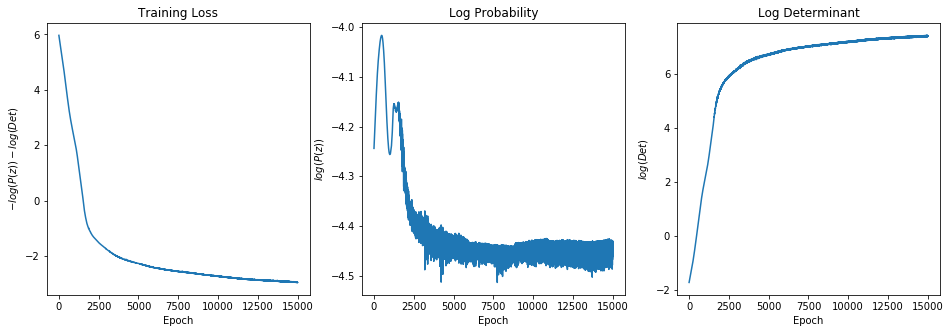

In [15]:
# Plot training NLL
fig, ax = plt.subplots(1, 3, figsize=(16, 5))

ax[0].plot(loss)
ax[1].plot(logpz)
ax[2].plot(logdet)


ax[0].set_title('Training Loss')
ax[0].set_ylabel(r'$-log(P(z)) - log(Det)$')
ax[0].set_xlabel('Epoch')

ax[1].set_title('Log Probability')
ax[1].set_ylabel(r'$log(P(z))$')
ax[1].set_xlabel('Epoch')

ax[2].set_title('Log Determinant')
ax[2].set_ylabel(r'$log(Det)$')
ax[2].set_xlabel('Epoch')

plt.show()

### GIF animation

In [16]:
preds, _ = model(torch_logits)
preds = preds.detach().numpy()

print(nll(softmax(preds, 1)))

1.1097903


In [17]:
ani = create_animation(intermediate_results)

In [18]:
HTML(ani.to_html5_video())

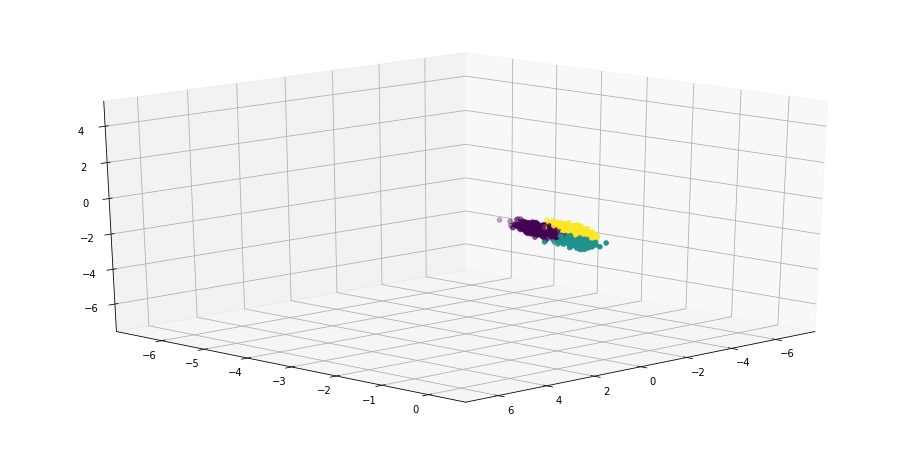

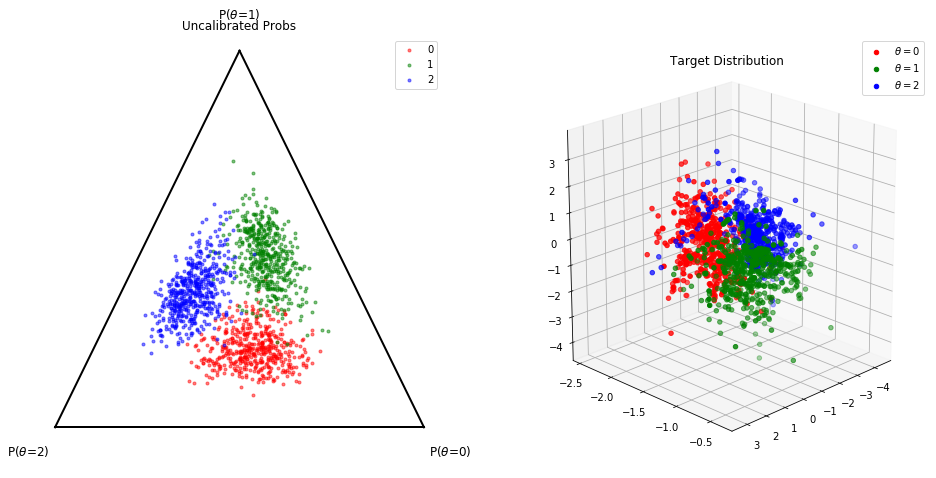

In [19]:
fig = plt.figure(figsize=(16, 8))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')
ax2.view_init(20, 45)

colors = ['r', 'g', 'b']
ax1 = plot_prob_simplex(probs, target, ax=ax1, title='Simulated Probabilities')
for i in range(3):
    ix = target==i
    ax2.scatter(preds[ix, 0], preds[ix, 1], preds[ix, 2], c=colors[i], label=r'$\theta={}$'.format(i))

    
ax1.set_title('Uncalibrated Probs')
ax2.set_title('Target Distribution')
ax2.legend()
plt.show()

# Logits to categorical

In [20]:
model2 = Flow(layers=[NvpCouplingLayer(dim, [5, 5], random_mask=False) for _ in range(10)])

### Train the model

In [21]:
epochs = 20000

In [22]:
model2 = model2.to(dev, non_blocking=True)

# Instantiate optimizer and loss function
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-5)

loss2 = []
logpz2 = []
logdet2 = []

softmx = nn.Softmax(dim=1)

intermediate_results2 = []

# Train loop
t0 = time.time()
for e in range(epochs):

    cum_loss = torch.zeros(1, device=dev)
    cum_logdet = torch.zeros(1, device=dev)
    cum_logprior = torch.zeros(1, device=dev)

    optimizer.zero_grad()

    preds, _logdet = model2(torch_logits)
    _probs = softmx(preds)

    _logdet = torch.mean(_logdet)
    _logpz = torch.mean(torch.log(_probs.gather(1, torch_target.view(-1, 1))))
    _loss = -_logpz - _logdet
    
    if (preds != preds).any():
        break

    _loss.backward()
    optimizer.step()

    loss2.append(_loss.item())
    logpz2.append(_logpz.item())
    logdet2.append(_logdet.item())

    if e%10 == 9:
        print('epoch: {}, at time: {:.2f}, loss: {:.3f}, log(pz): {:.3f}, log(det): {:.3f}'.format(e, time.time()-t0, loss2[-1], logpz2[-1], logdet2[-1]))
        intermediate_results2.append(preds.detach().numpy())

epoch: 9, at time: 0.63, loss: 1.792, log(pz): -1.180, log(det): -0.611
epoch: 19, at time: 1.27, loss: 1.786, log(pz): -1.180, log(det): -0.606
epoch: 29, at time: 1.97, loss: 1.780, log(pz): -1.179, log(det): -0.601
epoch: 39, at time: 2.63, loss: 1.774, log(pz): -1.178, log(det): -0.596
epoch: 49, at time: 3.32, loss: 1.768, log(pz): -1.177, log(det): -0.591
epoch: 59, at time: 4.00, loss: 1.762, log(pz): -1.176, log(det): -0.586
epoch: 69, at time: 4.66, loss: 1.756, log(pz): -1.176, log(det): -0.581
epoch: 79, at time: 5.34, loss: 1.750, log(pz): -1.175, log(det): -0.575
epoch: 89, at time: 6.03, loss: 1.744, log(pz): -1.174, log(det): -0.570
epoch: 99, at time: 6.61, loss: 1.738, log(pz): -1.173, log(det): -0.565
epoch: 109, at time: 7.30, loss: 1.732, log(pz): -1.172, log(det): -0.560
epoch: 119, at time: 7.98, loss: 1.726, log(pz): -1.172, log(det): -0.555
epoch: 129, at time: 8.66, loss: 1.721, log(pz): -1.171, log(det): -0.550
epoch: 139, at time: 9.36, loss: 1.715, log(pz): 

epoch: 1109, at time: 77.56, loss: 1.115, log(pz): -1.084, log(det): -0.031
epoch: 1119, at time: 78.25, loss: 1.109, log(pz): -1.083, log(det): -0.026
epoch: 1129, at time: 78.87, loss: 1.102, log(pz): -1.082, log(det): -0.020
epoch: 1139, at time: 79.55, loss: 1.096, log(pz): -1.081, log(det): -0.015
epoch: 1149, at time: 80.20, loss: 1.090, log(pz): -1.081, log(det): -0.009
epoch: 1159, at time: 80.87, loss: 1.083, log(pz): -1.080, log(det): -0.004
epoch: 1169, at time: 81.47, loss: 1.077, log(pz): -1.079, log(det): 0.002
epoch: 1179, at time: 82.12, loss: 1.071, log(pz): -1.078, log(det): 0.008
epoch: 1189, at time: 82.80, loss: 1.064, log(pz): -1.078, log(det): 0.013
epoch: 1199, at time: 83.46, loss: 1.058, log(pz): -1.077, log(det): 0.019
epoch: 1209, at time: 84.07, loss: 1.052, log(pz): -1.076, log(det): 0.024
epoch: 1219, at time: 84.77, loss: 1.046, log(pz): -1.075, log(det): 0.030
epoch: 1229, at time: 85.39, loss: 1.039, log(pz): -1.075, log(det): 0.035
epoch: 1239, at tim

epoch: 2199, at time: 148.40, loss: 0.458, log(pz): -1.020, log(det): 0.561
epoch: 2209, at time: 148.97, loss: 0.453, log(pz): -1.019, log(det): 0.567
epoch: 2219, at time: 149.64, loss: 0.447, log(pz): -1.019, log(det): 0.572
epoch: 2229, at time: 150.33, loss: 0.441, log(pz): -1.018, log(det): 0.577
epoch: 2239, at time: 150.96, loss: 0.435, log(pz): -1.018, log(det): 0.582
epoch: 2249, at time: 151.60, loss: 0.429, log(pz): -1.017, log(det): 0.588
epoch: 2259, at time: 152.23, loss: 0.424, log(pz): -1.017, log(det): 0.593
epoch: 2269, at time: 152.88, loss: 0.418, log(pz): -1.016, log(det): 0.598
epoch: 2279, at time: 153.46, loss: 0.412, log(pz): -1.016, log(det): 0.603
epoch: 2289, at time: 154.20, loss: 0.406, log(pz): -1.015, log(det): 0.609
epoch: 2299, at time: 154.86, loss: 0.401, log(pz): -1.015, log(det): 0.614
epoch: 2309, at time: 155.54, loss: 0.395, log(pz): -1.014, log(det): 0.619
epoch: 2319, at time: 156.20, loss: 0.389, log(pz): -1.013, log(det): 0.624
epoch: 2329,

epoch: 3279, at time: 218.98, loss: -0.140, log(pz): -0.968, log(det): 1.107
epoch: 3289, at time: 219.69, loss: -0.145, log(pz): -0.967, log(det): 1.112
epoch: 3299, at time: 220.32, loss: -0.150, log(pz): -0.967, log(det): 1.117
epoch: 3309, at time: 221.08, loss: -0.155, log(pz): -0.966, log(det): 1.122
epoch: 3319, at time: 221.73, loss: -0.160, log(pz): -0.966, log(det): 1.126
epoch: 3329, at time: 222.43, loss: -0.166, log(pz): -0.966, log(det): 1.131
epoch: 3339, at time: 223.10, loss: -0.171, log(pz): -0.965, log(det): 1.136
epoch: 3349, at time: 223.73, loss: -0.176, log(pz): -0.965, log(det): 1.141
epoch: 3359, at time: 224.41, loss: -0.181, log(pz): -0.964, log(det): 1.145
epoch: 3369, at time: 225.09, loss: -0.186, log(pz): -0.964, log(det): 1.150
epoch: 3379, at time: 225.78, loss: -0.191, log(pz): -0.964, log(det): 1.155
epoch: 3389, at time: 226.45, loss: -0.196, log(pz): -0.963, log(det): 1.160
epoch: 3399, at time: 227.09, loss: -0.202, log(pz): -0.963, log(det): 1.164

epoch: 4349, at time: 289.40, loss: -0.663, log(pz): -0.925, log(det): 1.588
epoch: 4359, at time: 290.10, loss: -0.667, log(pz): -0.925, log(det): 1.592
epoch: 4369, at time: 290.76, loss: -0.672, log(pz): -0.924, log(det): 1.596
epoch: 4379, at time: 291.44, loss: -0.677, log(pz): -0.924, log(det): 1.601
epoch: 4389, at time: 292.09, loss: -0.682, log(pz): -0.923, log(det): 1.605
epoch: 4399, at time: 292.66, loss: -0.686, log(pz): -0.923, log(det): 1.610
epoch: 4409, at time: 293.27, loss: -0.691, log(pz): -0.923, log(det): 1.614
epoch: 4419, at time: 293.98, loss: -0.696, log(pz): -0.922, log(det): 1.618
epoch: 4429, at time: 294.56, loss: -0.701, log(pz): -0.922, log(det): 1.623
epoch: 4439, at time: 295.20, loss: -0.705, log(pz): -0.922, log(det): 1.627
epoch: 4449, at time: 295.82, loss: -0.710, log(pz): -0.921, log(det): 1.631
epoch: 4459, at time: 296.57, loss: -0.715, log(pz): -0.921, log(det): 1.636
epoch: 4469, at time: 297.23, loss: -0.719, log(pz): -0.921, log(det): 1.640

epoch: 5419, at time: 359.20, loss: -1.174, log(pz): -0.904, log(det): 2.078
epoch: 5429, at time: 359.77, loss: -1.179, log(pz): -0.905, log(det): 2.084
epoch: 5439, at time: 360.41, loss: -1.184, log(pz): -0.905, log(det): 2.089
epoch: 5449, at time: 361.11, loss: -1.189, log(pz): -0.905, log(det): 2.094
epoch: 5459, at time: 361.77, loss: -1.194, log(pz): -0.905, log(det): 2.099
epoch: 5469, at time: 362.47, loss: -1.199, log(pz): -0.905, log(det): 2.104
epoch: 5479, at time: 363.09, loss: -1.204, log(pz): -0.905, log(det): 2.109
epoch: 5489, at time: 363.78, loss: -1.209, log(pz): -0.906, log(det): 2.115
epoch: 5499, at time: 364.46, loss: -1.214, log(pz): -0.906, log(det): 2.120
epoch: 5509, at time: 365.11, loss: -1.219, log(pz): -0.906, log(det): 2.125
epoch: 5519, at time: 365.80, loss: -1.224, log(pz): -0.906, log(det): 2.130
epoch: 5529, at time: 366.50, loss: -1.229, log(pz): -0.906, log(det): 2.135
epoch: 5539, at time: 367.07, loss: -1.234, log(pz): -0.906, log(det): 2.141

epoch: 6489, at time: 428.65, loss: -1.720, log(pz): -0.913, log(det): 2.633
epoch: 6499, at time: 429.23, loss: -1.725, log(pz): -0.913, log(det): 2.638
epoch: 6509, at time: 429.78, loss: -1.730, log(pz): -0.913, log(det): 2.644
epoch: 6519, at time: 430.42, loss: -1.736, log(pz): -0.913, log(det): 2.649
epoch: 6529, at time: 430.99, loss: -1.741, log(pz): -0.914, log(det): 2.654
epoch: 6539, at time: 431.71, loss: -1.746, log(pz): -0.914, log(det): 2.660
epoch: 6549, at time: 432.43, loss: -1.751, log(pz): -0.914, log(det): 2.665
epoch: 6559, at time: 433.03, loss: -1.756, log(pz): -0.914, log(det): 2.670
epoch: 6569, at time: 433.69, loss: -1.762, log(pz): -0.914, log(det): 2.676
epoch: 6579, at time: 434.31, loss: -1.767, log(pz): -0.914, log(det): 2.681
epoch: 6589, at time: 434.96, loss: -1.772, log(pz): -0.914, log(det): 2.686
epoch: 6599, at time: 435.52, loss: -1.777, log(pz): -0.914, log(det): 2.691
epoch: 6609, at time: 436.15, loss: -1.783, log(pz): -0.914, log(det): 2.697

epoch: 7559, at time: 497.76, loss: -2.286, log(pz): -0.919, log(det): 3.204
epoch: 7569, at time: 498.45, loss: -2.291, log(pz): -0.919, log(det): 3.210
epoch: 7579, at time: 499.11, loss: -2.296, log(pz): -0.919, log(det): 3.215
epoch: 7589, at time: 499.77, loss: -2.302, log(pz): -0.919, log(det): 3.221
epoch: 7599, at time: 500.47, loss: -2.307, log(pz): -0.919, log(det): 3.227
epoch: 7609, at time: 501.07, loss: -2.313, log(pz): -0.919, log(det): 3.232
epoch: 7619, at time: 501.71, loss: -2.318, log(pz): -0.920, log(det): 3.238
epoch: 7629, at time: 502.34, loss: -2.324, log(pz): -0.920, log(det): 3.243
epoch: 7639, at time: 503.02, loss: -2.329, log(pz): -0.920, log(det): 3.249
epoch: 7649, at time: 503.66, loss: -2.335, log(pz): -0.920, log(det): 3.255
epoch: 7659, at time: 504.31, loss: -2.340, log(pz): -0.920, log(det): 3.260
epoch: 7669, at time: 504.85, loss: -2.346, log(pz): -0.920, log(det): 3.266
epoch: 7679, at time: 505.53, loss: -2.351, log(pz): -0.920, log(det): 3.272

epoch: 8629, at time: 566.87, loss: -2.900, log(pz): -0.956, log(det): 3.856
epoch: 8639, at time: 567.48, loss: -2.906, log(pz): -0.957, log(det): 3.863
epoch: 8649, at time: 568.02, loss: -2.913, log(pz): -0.957, log(det): 3.870
epoch: 8659, at time: 568.72, loss: -2.919, log(pz): -0.958, log(det): 3.877
epoch: 8669, at time: 569.36, loss: -2.925, log(pz): -0.959, log(det): 3.884
epoch: 8679, at time: 569.99, loss: -2.932, log(pz): -0.959, log(det): 3.891
epoch: 8689, at time: 570.65, loss: -2.938, log(pz): -0.960, log(det): 3.898
epoch: 8699, at time: 571.30, loss: -2.945, log(pz): -0.961, log(det): 3.905
epoch: 8709, at time: 572.01, loss: -2.951, log(pz): -0.961, log(det): 3.912
epoch: 8719, at time: 572.59, loss: -2.957, log(pz): -0.962, log(det): 3.919
epoch: 8729, at time: 573.27, loss: -2.964, log(pz): -0.962, log(det): 3.926
epoch: 8739, at time: 573.93, loss: -2.970, log(pz): -0.963, log(det): 3.933
epoch: 8749, at time: 574.55, loss: -2.977, log(pz): -0.964, log(det): 3.940

epoch: 9699, at time: 635.54, loss: -3.665, log(pz): -1.074, log(det): 4.739
epoch: 9709, at time: 636.18, loss: -3.673, log(pz): -1.075, log(det): 4.748
epoch: 9719, at time: 636.81, loss: -3.681, log(pz): -1.076, log(det): 4.757
epoch: 9729, at time: 637.47, loss: -3.689, log(pz): -1.078, log(det): 4.767
epoch: 9739, at time: 638.11, loss: -3.696, log(pz): -1.079, log(det): 4.776
epoch: 9749, at time: 638.71, loss: -3.704, log(pz): -1.081, log(det): 4.785
epoch: 9759, at time: 639.36, loss: -3.712, log(pz): -1.082, log(det): 4.794
epoch: 9769, at time: 640.04, loss: -3.720, log(pz): -1.084, log(det): 4.804
epoch: 9779, at time: 640.66, loss: -3.728, log(pz): -1.085, log(det): 4.813
epoch: 9789, at time: 641.29, loss: -3.736, log(pz): -1.086, log(det): 4.822
epoch: 9799, at time: 641.97, loss: -3.744, log(pz): -1.088, log(det): 4.832
epoch: 9809, at time: 642.68, loss: -3.752, log(pz): -1.090, log(det): 4.841
epoch: 9819, at time: 643.35, loss: -3.760, log(pz): -1.091, log(det): 4.851

epoch: 10759, at time: 703.47, loss: -4.454, log(pz): -1.187, log(det): 5.641
epoch: 10769, at time: 704.12, loss: -4.460, log(pz): -1.187, log(det): 5.648
epoch: 10779, at time: 704.79, loss: -4.467, log(pz): -1.189, log(det): 5.656
epoch: 10789, at time: 705.39, loss: -4.474, log(pz): -1.190, log(det): 5.664
epoch: 10799, at time: 706.08, loss: -4.481, log(pz): -1.191, log(det): 5.672
epoch: 10809, at time: 706.76, loss: -4.488, log(pz): -1.193, log(det): 5.681
epoch: 10819, at time: 707.34, loss: -4.495, log(pz): -1.194, log(det): 5.690
epoch: 10829, at time: 708.00, loss: -4.502, log(pz): -1.196, log(det): 5.698
epoch: 10839, at time: 708.63, loss: -4.510, log(pz): -1.197, log(det): 5.707
epoch: 10849, at time: 709.34, loss: -4.517, log(pz): -1.199, log(det): 5.716
epoch: 10859, at time: 709.92, loss: -4.524, log(pz): -1.200, log(det): 5.725
epoch: 10869, at time: 710.53, loss: -4.528, log(pz): -1.200, log(det): 5.729
epoch: 10879, at time: 711.18, loss: -4.526, log(pz): -1.197, lo

epoch: 11819, at time: 772.63, loss: -5.171, log(pz): -1.286, log(det): 6.458
epoch: 11829, at time: 773.27, loss: -5.182, log(pz): -1.289, log(det): 6.471
epoch: 11839, at time: 773.88, loss: -5.193, log(pz): -1.292, log(det): 6.485
epoch: 11849, at time: 774.59, loss: -5.205, log(pz): -1.295, log(det): 6.500
epoch: 11859, at time: 775.21, loss: -5.216, log(pz): -1.298, log(det): 6.514
epoch: 11869, at time: 775.84, loss: -5.228, log(pz): -1.301, log(det): 6.530
epoch: 11879, at time: 776.48, loss: -5.241, log(pz): -1.305, log(det): 6.545
epoch: 11889, at time: 777.12, loss: -5.253, log(pz): -1.308, log(det): 6.561
epoch: 11899, at time: 777.77, loss: -5.266, log(pz): -1.312, log(det): 6.578
epoch: 11909, at time: 778.39, loss: -5.279, log(pz): -1.315, log(det): 6.595
epoch: 11919, at time: 779.11, loss: -5.293, log(pz): -1.319, log(det): 6.612
epoch: 11929, at time: 779.79, loss: -5.307, log(pz): -1.323, log(det): 6.630
epoch: 11939, at time: 780.48, loss: -5.314, log(pz): -1.329, lo

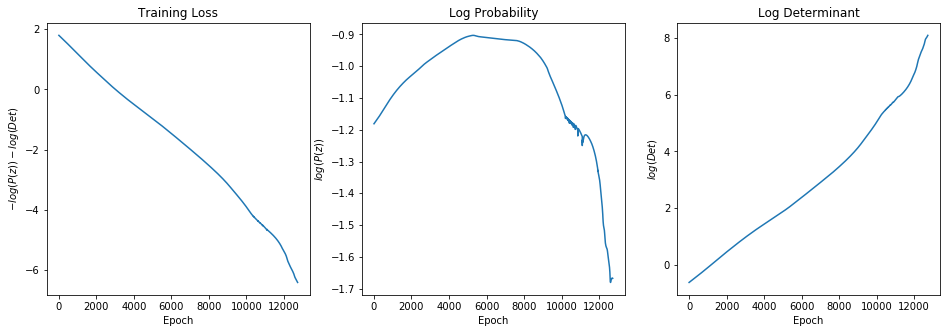

In [23]:
# Plot training NLL
fig, ax = plt.subplots(1, 3, figsize=(16, 5))

ax[0].plot(loss2)
ax[1].plot(logpz2)
ax[2].plot(logdet2)


ax[0].set_title('Training Loss')
ax[0].set_ylabel(r'$-log(P(z)) - log(Det)$')
ax[0].set_xlabel('Epoch')

ax[1].set_title('Log Probability')
ax[1].set_ylabel(r'$log(P(z))$')
ax[1].set_xlabel('Epoch')

ax[2].set_title('Log Determinant')
ax[2].set_ylabel(r'$log(Det)$')
ax[2].set_xlabel('Epoch')

plt.show()

In [24]:
preds2, _ = model2(torch_logits)
preds2 = preds2.detach().numpy()

print(nll(softmax(preds2, 1)))

nan


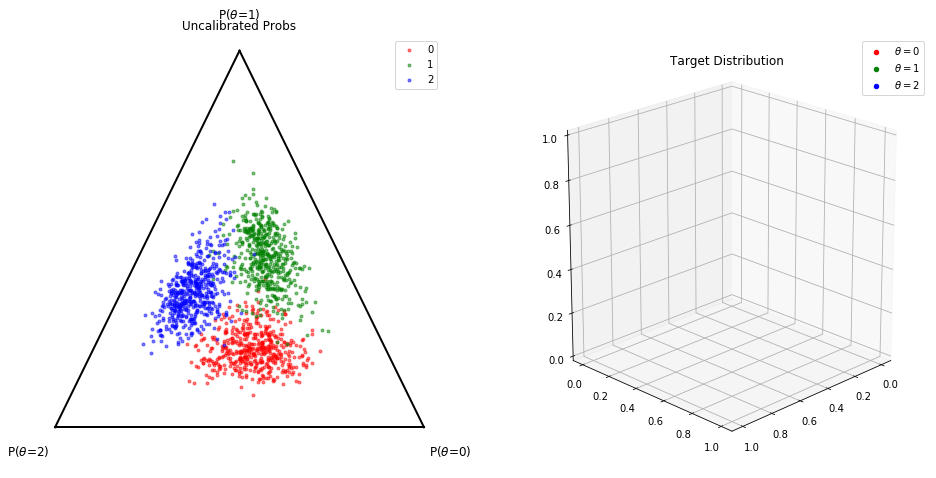

In [25]:
fig = plt.figure(figsize=(16, 8))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')
ax2.view_init(20, 45)

colors = ['r', 'g', 'b']
ax1 = plot_prob_simplex(probs, target, ax=ax1, title='Simulated Probabilities')
for i in range(3):
    ix = target==i
    ax2.scatter(preds2[ix, 0], preds2[ix, 1], preds2[ix, 2], c=colors[i], label=r'$\theta={}$'.format(i))

    
ax1.set_title('Uncalibrated Probs')
ax2.set_title('Target Distribution')
ax2.legend()
plt.show()

In [26]:
ani2 = create_animation(intermediate_results2)

In [27]:
HTML(ani2.to_html5_video())

## Limit logit magnitude

In [28]:
MAX_ABS = 1
model3 = Flow(layers=[NvpCouplingLayer(dim, [5, 5], random_mask=False, max_abs=MAX_ABS) for _ in range(10)])

In [29]:
model3 = model3.to(dev, non_blocking=True)
epochs = 15000

# Instantiate optimizer and loss function
optimizer = torch.optim.Adam(model3.parameters(), lr=1e-4)

loss3 = []
logpz3 = []
logdet3 = []

softmx = nn.Softmax(dim=1)

intermediate_results3 = []

# Train loop
t0 = time.time()
for e in range(epochs):

    cum_loss = torch.zeros(1, device=dev)
    cum_logdet = torch.zeros(1, device=dev)
    cum_logprior = torch.zeros(1, device=dev)

    optimizer.zero_grad()

    preds, _logdet = model3(torch_logits)
    _probs = softmx(preds)

    _logdet = torch.mean(_logdet)
    _logpz = torch.mean(torch.log(_probs.gather(1, torch_target.view(-1, 1))))
    _loss = -_logpz - _logdet
    
    if (preds != preds).any():
        break

    _loss.backward()
    optimizer.step()

    loss3.append(_loss.item())
    logpz3.append(_logpz.item())
    logdet3.append(_logdet.item())

    if e%10 == 9:
        print('epoch: {}, at time: {:.2f}, loss: {:.3f}, log(pz): {:.3f}, log(det): {:.3f}'.format(e, time.time()-t0, loss3[-1], logpz3[-1], logdet3[-1]))
        intermediate_results3.append(preds.detach().numpy())

epoch: 9, at time: 0.72, loss: 37.033, log(pz): -1.019, log(det): -36.014
epoch: 19, at time: 1.43, loss: 36.429, log(pz): -1.016, log(det): -35.412
epoch: 29, at time: 2.05, loss: 35.842, log(pz): -1.015, log(det): -34.827
epoch: 39, at time: 2.68, loss: 35.271, log(pz): -1.014, log(det): -34.258
epoch: 49, at time: 3.42, loss: 34.717, log(pz): -1.013, log(det): -33.704
epoch: 59, at time: 4.07, loss: 34.178, log(pz): -1.013, log(det): -33.165
epoch: 69, at time: 4.80, loss: 33.651, log(pz): -1.013, log(det): -32.638
epoch: 79, at time: 5.50, loss: 33.137, log(pz): -1.014, log(det): -32.123
epoch: 89, at time: 6.17, loss: 32.634, log(pz): -1.015, log(det): -31.619
epoch: 99, at time: 6.80, loss: 32.141, log(pz): -1.017, log(det): -31.124
epoch: 109, at time: 7.51, loss: 31.658, log(pz): -1.019, log(det): -30.638
epoch: 119, at time: 8.25, loss: 31.183, log(pz): -1.022, log(det): -30.161
epoch: 129, at time: 8.94, loss: 30.717, log(pz): -1.024, log(det): -29.693
epoch: 139, at time: 9.

epoch: 1079, at time: 76.18, loss: 15.839, log(pz): -0.972, log(det): -14.867
epoch: 1089, at time: 76.93, loss: 15.776, log(pz): -0.969, log(det): -14.807
epoch: 1099, at time: 77.69, loss: 15.713, log(pz): -0.966, log(det): -14.747
epoch: 1109, at time: 78.35, loss: 15.650, log(pz): -0.963, log(det): -14.688
epoch: 1119, at time: 79.06, loss: 15.587, log(pz): -0.960, log(det): -14.628
epoch: 1129, at time: 79.80, loss: 15.525, log(pz): -0.957, log(det): -14.568
epoch: 1139, at time: 80.56, loss: 15.462, log(pz): -0.955, log(det): -14.508
epoch: 1149, at time: 81.35, loss: 15.400, log(pz): -0.952, log(det): -14.447
epoch: 1159, at time: 82.05, loss: 15.337, log(pz): -0.950, log(det): -14.387
epoch: 1169, at time: 82.79, loss: 15.275, log(pz): -0.948, log(det): -14.327
epoch: 1179, at time: 83.48, loss: 15.213, log(pz): -0.947, log(det): -14.266
epoch: 1189, at time: 84.26, loss: 15.150, log(pz): -0.945, log(det): -14.205
epoch: 1199, at time: 85.00, loss: 15.088, log(pz): -0.944, log(

epoch: 2129, at time: 150.26, loss: 10.676, log(pz): -1.255, log(det): -9.421
epoch: 2139, at time: 150.96, loss: 10.640, log(pz): -1.257, log(det): -9.383
epoch: 2149, at time: 151.67, loss: 10.605, log(pz): -1.259, log(det): -9.346
epoch: 2159, at time: 152.31, loss: 10.570, log(pz): -1.262, log(det): -9.308
epoch: 2169, at time: 153.08, loss: 10.534, log(pz): -1.264, log(det): -9.271
epoch: 2179, at time: 153.83, loss: 10.499, log(pz): -1.266, log(det): -9.233
epoch: 2189, at time: 154.52, loss: 10.464, log(pz): -1.269, log(det): -9.194
epoch: 2199, at time: 155.25, loss: 10.428, log(pz): -1.271, log(det): -9.157
epoch: 2209, at time: 155.90, loss: 10.393, log(pz): -1.273, log(det): -9.120
epoch: 2219, at time: 156.62, loss: 10.358, log(pz): -1.275, log(det): -9.084
epoch: 2229, at time: 157.27, loss: 10.325, log(pz): -1.277, log(det): -9.047
epoch: 2239, at time: 157.91, loss: 10.292, log(pz): -1.280, log(det): -9.013
epoch: 2249, at time: 158.61, loss: 10.260, log(pz): -1.281, log

epoch: 3199, at time: 226.19, loss: 6.928, log(pz): -0.974, log(det): -5.954
epoch: 3209, at time: 226.90, loss: 6.898, log(pz): -0.971, log(det): -5.926
epoch: 3219, at time: 227.66, loss: 6.874, log(pz): -0.974, log(det): -5.900
epoch: 3229, at time: 228.42, loss: 6.846, log(pz): -0.966, log(det): -5.880
epoch: 3239, at time: 229.22, loss: 6.853, log(pz): -0.961, log(det): -5.892
epoch: 3249, at time: 229.97, loss: 6.797, log(pz): -0.957, log(det): -5.840
epoch: 3259, at time: 230.69, loss: 6.766, log(pz): -0.958, log(det): -5.808
epoch: 3269, at time: 231.40, loss: 6.740, log(pz): -0.953, log(det): -5.787
epoch: 3279, at time: 232.08, loss: 6.719, log(pz): -0.955, log(det): -5.764
epoch: 3289, at time: 232.79, loss: 6.692, log(pz): -0.950, log(det): -5.742
epoch: 3299, at time: 233.52, loss: 6.670, log(pz): -0.948, log(det): -5.722
epoch: 3309, at time: 234.22, loss: 6.655, log(pz): -0.948, log(det): -5.707
epoch: 3319, at time: 234.98, loss: 6.637, log(pz): -0.945, log(det): -5.692

epoch: 4269, at time: 301.99, loss: 5.827, log(pz): -0.855, log(det): -4.972
epoch: 4279, at time: 302.68, loss: 5.815, log(pz): -0.865, log(det): -4.950
epoch: 4289, at time: 303.31, loss: 5.807, log(pz): -0.856, log(det): -4.951
epoch: 4299, at time: 303.90, loss: 5.800, log(pz): -0.858, log(det): -4.942
epoch: 4309, at time: 304.70, loss: 5.795, log(pz): -0.857, log(det): -4.938
epoch: 4319, at time: 305.42, loss: 5.789, log(pz): -0.863, log(det): -4.926
epoch: 4329, at time: 306.09, loss: 5.799, log(pz): -0.852, log(det): -4.947
epoch: 4339, at time: 306.82, loss: 5.794, log(pz): -0.870, log(det): -4.923
epoch: 4349, at time: 307.50, loss: 5.797, log(pz): -0.873, log(det): -4.924
epoch: 4359, at time: 308.17, loss: 5.770, log(pz): -0.864, log(det): -4.906
epoch: 4369, at time: 308.86, loss: 5.759, log(pz): -0.857, log(det): -4.902
epoch: 4379, at time: 309.56, loss: 5.758, log(pz): -0.865, log(det): -4.893
epoch: 4389, at time: 310.19, loss: 5.752, log(pz): -0.865, log(det): -4.887

epoch: 5339, at time: 377.68, loss: 5.163, log(pz): -0.848, log(det): -4.315
epoch: 5349, at time: 378.44, loss: 5.166, log(pz): -0.845, log(det): -4.321
epoch: 5359, at time: 379.11, loss: 5.155, log(pz): -0.856, log(det): -4.299
epoch: 5369, at time: 379.76, loss: 5.153, log(pz): -0.847, log(det): -4.306
epoch: 5379, at time: 380.43, loss: 5.150, log(pz): -0.856, log(det): -4.294
epoch: 5389, at time: 381.07, loss: 5.148, log(pz): -0.845, log(det): -4.304
epoch: 5399, at time: 381.82, loss: 5.138, log(pz): -0.851, log(det): -4.287
epoch: 5409, at time: 382.59, loss: 5.135, log(pz): -0.849, log(det): -4.287
epoch: 5419, at time: 383.34, loss: 5.143, log(pz): -0.862, log(det): -4.281
epoch: 5429, at time: 384.01, loss: 5.149, log(pz): -0.840, log(det): -4.309
epoch: 5439, at time: 384.71, loss: 5.127, log(pz): -0.857, log(det): -4.270
epoch: 5449, at time: 385.45, loss: 5.124, log(pz): -0.857, log(det): -4.267
epoch: 5459, at time: 386.18, loss: 5.123, log(pz): -0.860, log(det): -4.263

epoch: 6409, at time: 453.64, loss: 4.834, log(pz): -0.839, log(det): -3.995
epoch: 6419, at time: 454.34, loss: 4.828, log(pz): -0.862, log(det): -3.966
epoch: 6429, at time: 455.02, loss: 4.810, log(pz): -0.852, log(det): -3.958
epoch: 6439, at time: 455.75, loss: 4.811, log(pz): -0.848, log(det): -3.962
epoch: 6449, at time: 456.48, loss: 4.809, log(pz): -0.846, log(det): -3.962
epoch: 6459, at time: 457.15, loss: 4.803, log(pz): -0.849, log(det): -3.954
epoch: 6469, at time: 457.88, loss: 4.799, log(pz): -0.850, log(det): -3.950
epoch: 6479, at time: 458.55, loss: 4.798, log(pz): -0.849, log(det): -3.949
epoch: 6489, at time: 459.30, loss: 4.794, log(pz): -0.849, log(det): -3.946
epoch: 6499, at time: 459.99, loss: 4.792, log(pz): -0.848, log(det): -3.943
epoch: 6509, at time: 460.74, loss: 4.790, log(pz): -0.849, log(det): -3.941
epoch: 6519, at time: 461.45, loss: 4.791, log(pz): -0.845, log(det): -3.946
epoch: 6529, at time: 462.17, loss: 4.784, log(pz): -0.847, log(det): -3.937

epoch: 7479, at time: 530.21, loss: 4.560, log(pz): -0.881, log(det): -3.679
epoch: 7489, at time: 531.01, loss: 4.558, log(pz): -0.863, log(det): -3.695
epoch: 7499, at time: 531.84, loss: 4.557, log(pz): -0.882, log(det): -3.675
epoch: 7509, at time: 532.59, loss: 4.558, log(pz): -0.861, log(det): -3.697
epoch: 7519, at time: 533.35, loss: 4.554, log(pz): -0.882, log(det): -3.671
epoch: 7529, at time: 534.01, loss: 4.561, log(pz): -0.856, log(det): -3.704
epoch: 7539, at time: 534.72, loss: 4.543, log(pz): -0.872, log(det): -3.671
epoch: 7549, at time: 535.44, loss: 4.544, log(pz): -0.877, log(det): -3.666
epoch: 7559, at time: 536.18, loss: 4.555, log(pz): -0.856, log(det): -3.699
epoch: 7569, at time: 536.89, loss: 4.539, log(pz): -0.868, log(det): -3.671
epoch: 7579, at time: 537.59, loss: 4.541, log(pz): -0.881, log(det): -3.661
epoch: 7589, at time: 538.28, loss: 4.556, log(pz): -0.854, log(det): -3.703
epoch: 7599, at time: 538.99, loss: 4.540, log(pz): -0.884, log(det): -3.656

epoch: 8549, at time: 609.89, loss: 4.403, log(pz): -0.878, log(det): -3.525
epoch: 8559, at time: 610.61, loss: 4.403, log(pz): -0.875, log(det): -3.528
epoch: 8569, at time: 611.36, loss: 4.401, log(pz): -0.874, log(det): -3.527
epoch: 8579, at time: 612.15, loss: 4.405, log(pz): -0.869, log(det): -3.536
epoch: 8589, at time: 612.92, loss: 4.401, log(pz): -0.870, log(det): -3.531
epoch: 8599, at time: 613.70, loss: 4.399, log(pz): -0.873, log(det): -3.525
epoch: 8609, at time: 614.46, loss: 4.398, log(pz): -0.884, log(det): -3.514
epoch: 8619, at time: 615.28, loss: 4.405, log(pz): -0.895, log(det): -3.511
epoch: 8629, at time: 616.09, loss: 4.400, log(pz): -0.868, log(det): -3.532
epoch: 8639, at time: 616.85, loss: 4.397, log(pz): -0.869, log(det): -3.528
epoch: 8649, at time: 617.60, loss: 4.402, log(pz): -0.894, log(det): -3.508
epoch: 8659, at time: 618.35, loss: 4.402, log(pz): -0.895, log(det): -3.507
epoch: 8669, at time: 619.13, loss: 4.391, log(pz): -0.882, log(det): -3.508

epoch: 9619, at time: 689.64, loss: 4.287, log(pz): -0.879, log(det): -3.408
epoch: 9629, at time: 690.34, loss: 4.288, log(pz): -0.873, log(det): -3.415
epoch: 9639, at time: 691.06, loss: 4.285, log(pz): -0.878, log(det): -3.407
epoch: 9649, at time: 691.79, loss: 4.287, log(pz): -0.872, log(det): -3.416
epoch: 9659, at time: 692.43, loss: 4.285, log(pz): -0.872, log(det): -3.413
epoch: 9669, at time: 693.20, loss: 4.286, log(pz): -0.871, log(det): -3.415
epoch: 9679, at time: 693.93, loss: 4.287, log(pz): -0.868, log(det): -3.419
epoch: 9689, at time: 694.65, loss: 4.283, log(pz): -0.871, log(det): -3.412
epoch: 9699, at time: 695.48, loss: 4.285, log(pz): -0.892, log(det): -3.393
epoch: 9709, at time: 696.24, loss: 4.283, log(pz): -0.891, log(det): -3.392
epoch: 9719, at time: 697.00, loss: 4.279, log(pz): -0.885, log(det): -3.394
epoch: 9729, at time: 697.78, loss: 4.281, log(pz): -0.891, log(det): -3.389
epoch: 9739, at time: 698.48, loss: 4.279, log(pz): -0.889, log(det): -3.390

epoch: 10679, at time: 765.78, loss: 4.182, log(pz): -0.874, log(det): -3.307
epoch: 10689, at time: 766.53, loss: 4.181, log(pz): -0.871, log(det): -3.310
epoch: 10699, at time: 767.32, loss: 4.181, log(pz): -0.879, log(det): -3.302
epoch: 10709, at time: 768.04, loss: 4.179, log(pz): -0.869, log(det): -3.310
epoch: 10719, at time: 768.77, loss: 4.178, log(pz): -0.870, log(det): -3.309
epoch: 10729, at time: 769.42, loss: 4.178, log(pz): -0.878, log(det): -3.301
epoch: 10739, at time: 770.05, loss: 4.177, log(pz): -0.867, log(det): -3.310
epoch: 10749, at time: 770.86, loss: 4.175, log(pz): -0.871, log(det): -3.305
epoch: 10759, at time: 771.68, loss: 4.174, log(pz): -0.872, log(det): -3.302
epoch: 10769, at time: 772.41, loss: 4.175, log(pz): -0.867, log(det): -3.308
epoch: 10779, at time: 773.16, loss: 4.173, log(pz): -0.869, log(det): -3.304
epoch: 10789, at time: 773.92, loss: 4.172, log(pz): -0.873, log(det): -3.299
epoch: 10799, at time: 774.70, loss: 4.171, log(pz): -0.870, log

epoch: 11739, at time: 842.57, loss: 4.097, log(pz): -0.857, log(det): -3.240
epoch: 11749, at time: 843.37, loss: 4.092, log(pz): -0.886, log(det): -3.206
epoch: 11759, at time: 844.09, loss: 4.087, log(pz): -0.866, log(det): -3.222
epoch: 11769, at time: 844.87, loss: 4.085, log(pz): -0.868, log(det): -3.217
epoch: 11779, at time: 845.56, loss: 4.086, log(pz): -0.865, log(det): -3.221
epoch: 11789, at time: 846.35, loss: 4.084, log(pz): -0.866, log(det): -3.218
epoch: 11799, at time: 847.02, loss: 4.102, log(pz): -0.899, log(det): -3.203
epoch: 11809, at time: 847.78, loss: 4.081, log(pz): -0.876, log(det): -3.205
epoch: 11819, at time: 848.54, loss: 4.081, log(pz): -0.878, log(det): -3.203
epoch: 11829, at time: 849.17, loss: 4.079, log(pz): -0.872, log(det): -3.207
epoch: 11839, at time: 849.89, loss: 4.087, log(pz): -0.858, log(det): -3.229
epoch: 11849, at time: 850.61, loss: 4.078, log(pz): -0.878, log(det): -3.200
epoch: 11859, at time: 851.39, loss: 4.076, log(pz): -0.871, log

epoch: 12799, at time: 918.46, loss: 4.023, log(pz): -0.846, log(det): -3.178
epoch: 12809, at time: 919.13, loss: 3.998, log(pz): -0.876, log(det): -3.122
epoch: 12819, at time: 919.85, loss: 3.996, log(pz): -0.871, log(det): -3.125
epoch: 12829, at time: 920.58, loss: 3.997, log(pz): -0.876, log(det): -3.120
epoch: 12839, at time: 921.14, loss: 4.004, log(pz): -0.889, log(det): -3.115
epoch: 12849, at time: 921.82, loss: 3.993, log(pz): -0.869, log(det): -3.125
epoch: 12859, at time: 922.58, loss: 4.013, log(pz): -0.849, log(det): -3.164
epoch: 12869, at time: 923.24, loss: 4.035, log(pz): -0.910, log(det): -3.124
epoch: 12879, at time: 923.94, loss: 4.001, log(pz): -0.854, log(det): -3.147
epoch: 12889, at time: 924.62, loss: 3.992, log(pz): -0.862, log(det): -3.130
epoch: 12899, at time: 925.32, loss: 3.998, log(pz): -0.856, log(det): -3.141
epoch: 12909, at time: 926.00, loss: 3.989, log(pz): -0.868, log(det): -3.120
epoch: 12919, at time: 926.72, loss: 4.020, log(pz): -0.905, log

epoch: 13859, at time: 994.35, loss: 3.930, log(pz): -0.855, log(det): -3.075
epoch: 13869, at time: 995.05, loss: 3.926, log(pz): -0.860, log(det): -3.066
epoch: 13879, at time: 995.80, loss: 3.924, log(pz): -0.861, log(det): -3.063
epoch: 13889, at time: 996.55, loss: 3.958, log(pz): -0.909, log(det): -3.049
epoch: 13899, at time: 997.15, loss: 3.925, log(pz): -0.858, log(det): -3.067
epoch: 13909, at time: 997.77, loss: 3.944, log(pz): -0.902, log(det): -3.042
epoch: 13919, at time: 998.51, loss: 3.929, log(pz): -0.853, log(det): -3.076
epoch: 13929, at time: 999.28, loss: 3.928, log(pz): -0.854, log(det): -3.074
epoch: 13939, at time: 1000.09, loss: 3.926, log(pz): -0.855, log(det): -3.071
epoch: 13949, at time: 1000.88, loss: 3.928, log(pz): -0.853, log(det): -3.075
epoch: 13959, at time: 1001.63, loss: 3.917, log(pz): -0.864, log(det): -3.052
epoch: 13969, at time: 1002.36, loss: 4.007, log(pz): -0.826, log(det): -3.181
epoch: 13979, at time: 1003.07, loss: 3.966, log(pz): -0.915

epoch: 14899, at time: 1069.67, loss: 3.859, log(pz): -0.859, log(det): -3.000
epoch: 14909, at time: 1070.39, loss: 3.874, log(pz): -0.899, log(det): -2.975
epoch: 14919, at time: 1071.15, loss: 3.851, log(pz): -0.870, log(det): -2.982
epoch: 14929, at time: 1071.89, loss: 3.853, log(pz): -0.862, log(det): -2.991
epoch: 14939, at time: 1072.57, loss: 3.854, log(pz): -0.862, log(det): -2.992
epoch: 14949, at time: 1073.26, loss: 3.859, log(pz): -0.856, log(det): -3.004
epoch: 14959, at time: 1074.01, loss: 3.850, log(pz): -0.865, log(det): -2.985
epoch: 14969, at time: 1074.87, loss: 3.868, log(pz): -0.897, log(det): -2.970
epoch: 14979, at time: 1075.69, loss: 3.849, log(pz): -0.879, log(det): -2.970
epoch: 14989, at time: 1076.42, loss: 3.852, log(pz): -0.860, log(det): -2.992
epoch: 14999, at time: 1077.29, loss: 3.860, log(pz): -0.853, log(det): -3.007


In [30]:
preds3, _ = model3(torch_logits)
preds3 = preds3.detach().numpy()

print(nll(softmax(preds3, 1)))

0.89120454


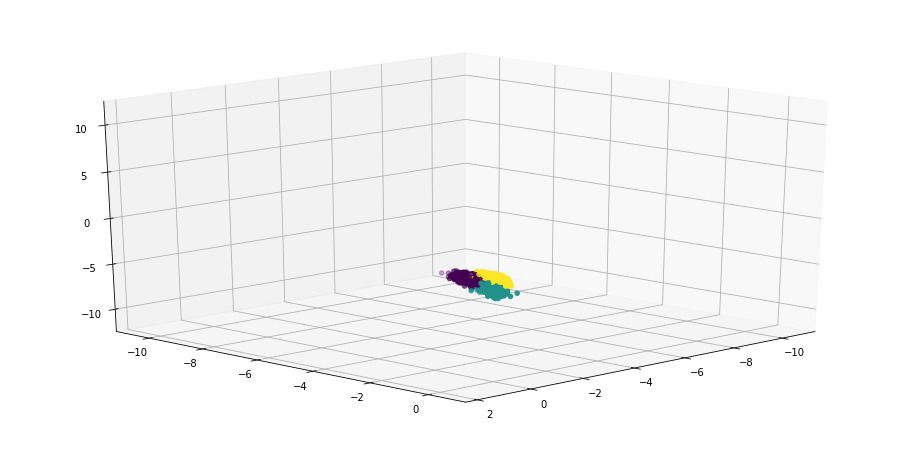

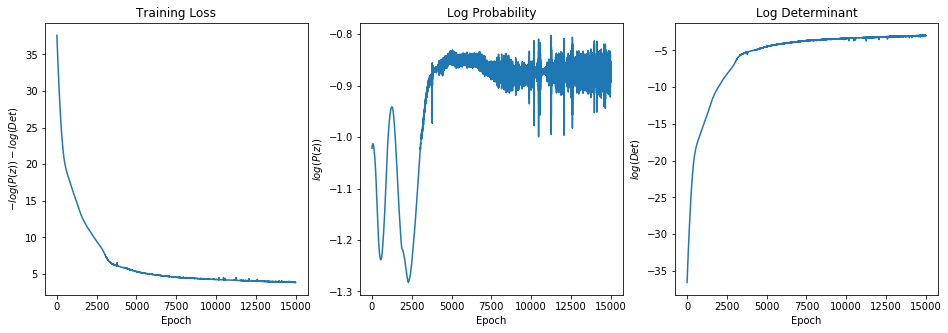

In [31]:
# Plot training NLL
fig, ax = plt.subplots(1, 3, figsize=(16, 5))

ax[0].plot(loss3)
ax[1].plot(logpz3)
ax[2].plot(logdet3)


ax[0].set_title('Training Loss')
ax[0].set_ylabel(r'$-log(P(z)) - log(Det)$')
ax[0].set_xlabel('Epoch')

ax[1].set_title('Log Probability')
ax[1].set_ylabel(r'$log(P(z))$')
ax[1].set_xlabel('Epoch')

ax[2].set_title('Log Determinant')
ax[2].set_ylabel(r'$log(Det)$')
ax[2].set_xlabel('Epoch')

plt.show()

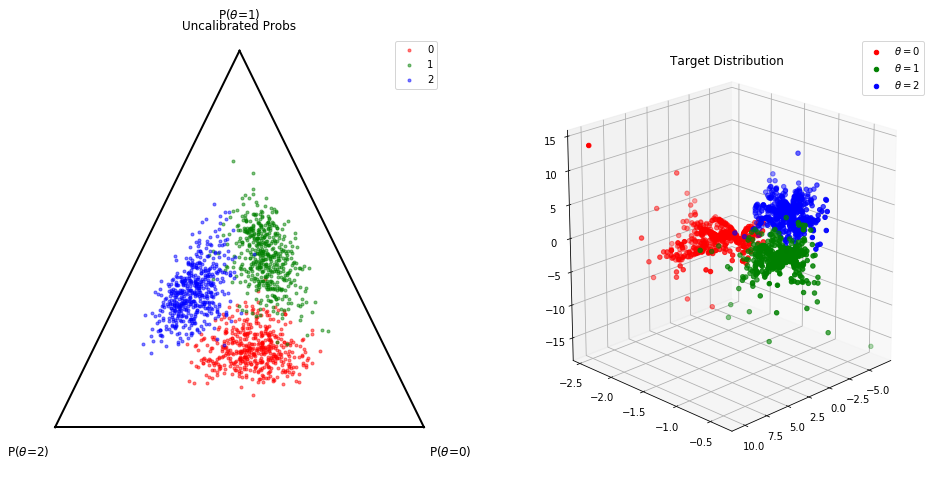

In [32]:
fig = plt.figure(figsize=(16, 8))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')
ax2.view_init(20, 45)

colors = ['r', 'g', 'b']
ax1 = plot_prob_simplex(probs, target, ax=ax1, title='Simulated Probabilities')
for i in range(3):
    ix = target==i
    ax2.scatter(preds3[ix, 0], preds3[ix, 1], preds3[ix, 2], c=colors[i], label=r'$\theta={}$'.format(i))

    
ax1.set_title('Uncalibrated Probs')
ax2.set_title('Target Distribution')
ax2.legend()
plt.show()

In [33]:
ani3 = create_animation(intermediate_results3)

In [34]:
HTML(ani3.to_html5_video())

## Mapping to D-1

In [35]:
logits -= np.mean(np.sum(logits, axis=1, keepdims=True))
logits_2d = logits[:, :2]

torch_logits_2d = torch.as_tensor(logits_2d, dtype=torch.float)

In [36]:
model4 = Flow(layers=[AffineConstantLayer(dim-1) for _ in range(10)])
dev = torch.device('cpu')

In [37]:
model4 = model4.to(dev, non_blocking=True)
epochs = 100000

# Instantiate optimizer and loss function
optimizer = torch.optim.Adam(model4.parameters(), lr=1e-5)

loss4 = []
logpz4 = []
logdet4 = []

softmx = nn.Softmax(dim=1)

intermediate_results4 = []

# Train loop
t0 = time.time()
for e in range(epochs):

    cum_loss = torch.zeros(1, device=dev)
    cum_logdet = torch.zeros(1, device=dev)
    cum_logprior = torch.zeros(1, device=dev)

    optimizer.zero_grad()

    preds, _logdet = model4(torch_logits_2d)
    preds = torch.cat((preds, -torch.sum(preds, 1, keepdims=True)), 1)
    _probs = softmx(preds)

    _logdet = torch.mean(_logdet)
    _logpz = torch.mean(torch.log(_probs.gather(1, torch_target.view(-1, 1))))
    _loss = -_logpz - _logdet
    
    if (preds != preds).any():
        break

    _loss.backward()
    optimizer.step()

    loss4.append(_loss.item())
    logpz4.append(_logpz.item())
    logdet4.append(_logdet.item())

    if e%100 == 0:
        print('epoch: {}, at time: {:.2f}, loss: {:.3f}, log(pz): {:.3f}, log(det): {:.3f}'.format(e, time.time()-t0, loss4[-1], logpz4[-1], logdet4[-1]))
        intermediate_results4.append(preds.detach().numpy())

epoch: 0, at time: 0.01, loss: inf, log(pz): -inf, log(det): 6.666


In [38]:
preds4, _ = model4(torch_logits_2d)
preds4 = torch.cat((preds4, -torch.sum(preds4, 1, keepdims=True)), 1)
preds4 = preds4.detach().numpy()


print(nll(softmax(preds4, 1)))

nan


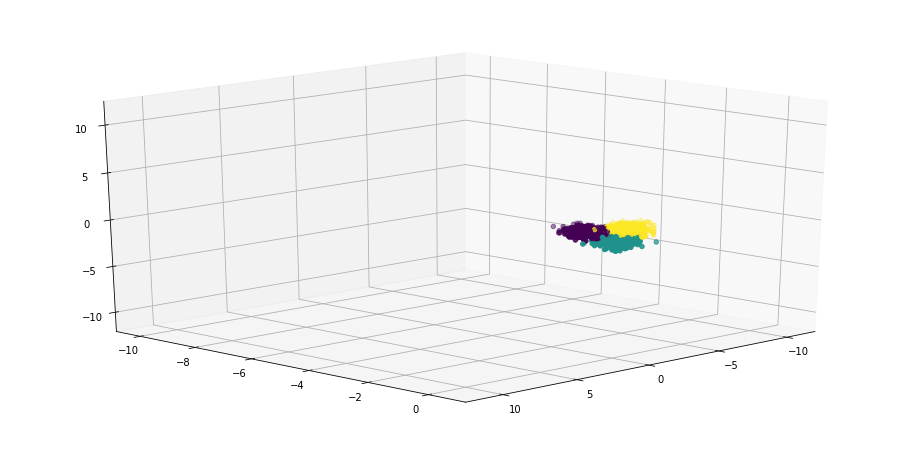

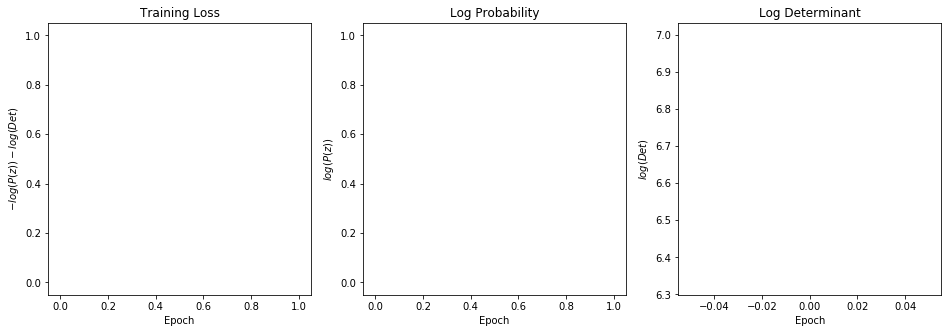

In [39]:
# Plot training NLL
fig, ax = plt.subplots(1, 3, figsize=(16, 5))

ax[0].plot(loss4)
ax[1].plot(logpz4)
ax[2].plot(logdet4)


ax[0].set_title('Training Loss')
ax[0].set_ylabel(r'$-log(P(z)) - log(Det)$')
ax[0].set_xlabel('Epoch')

ax[1].set_title('Log Probability')
ax[1].set_ylabel(r'$log(P(z))$')
ax[1].set_xlabel('Epoch')

ax[2].set_title('Log Determinant')
ax[2].set_ylabel(r'$log(Det)$')
ax[2].set_xlabel('Epoch')

plt.show()

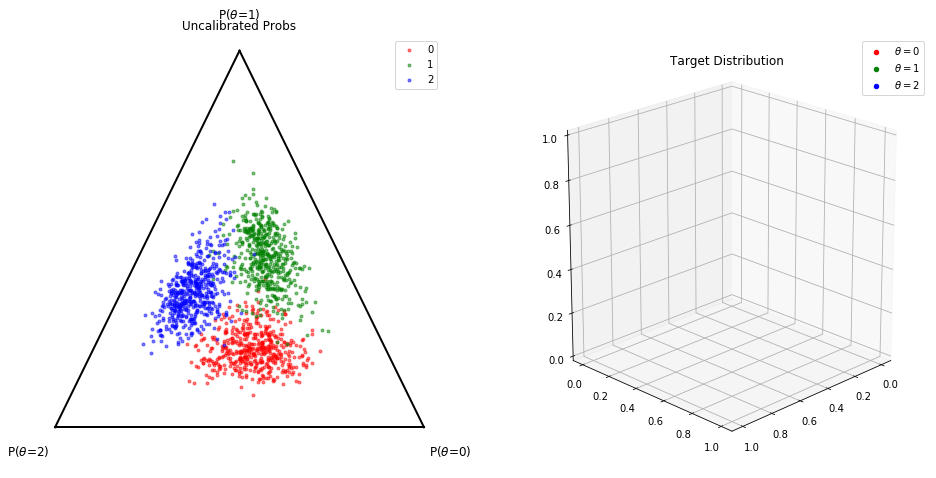

In [40]:
fig = plt.figure(figsize=(16, 8))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')
ax2.view_init(20, 45)

colors = ['r', 'g', 'b']
ax1 = plot_prob_simplex(probs, target, ax=ax1, title='Simulated Probabilities')
for i in range(3):
    ix = target==i
    ax2.scatter(preds4[ix, 0], preds4[ix, 1], preds4[ix, 2], c=colors[i], label=r'$\theta={}$'.format(i))

    
ax1.set_title('Uncalibrated Probs')
ax2.set_title('Target Distribution')
ax2.legend()
plt.show()

In [41]:
ani4 = create_animation(intermediate_results4)

In [42]:
HTML(ani4.to_html5_video())